In [1]:
import pandas as pd
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats import norm
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, recall_score

![Matrix](./media/1.png)*

In [3]:
# Load the dataset and replace "ONBEKEND" with NaN
file_path = './data/examen2.csv'
ex_dataset2 = pd.read_csv(file_path, delimiter=';', na_values='ONBEKEND', decimal=',')

# Selecting features and target variable
X = ex_dataset2[['bedrag', 'massa', 'temperatuur (Kelvin)']]
y = ex_dataset2['prijs']

# Ensure there are no NaNs in the target variable
mask = y.notna()
X = X[mask]
y = y[mask]

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_imputed, y)

# Predicting the discriminant function score for the given conditions
# bedrag = 1700, massa = 77.3, temperatuur = 290K
score = lda.decision_function(np.array([[1700, 77.3, 290]]))

print(score)
print(y.unique())

# Discriminantfunctiescore voor brons = `-0.62611452`

[[-2.5279359  -1.30239738 -0.62611452 -1.98394488]]
['geen' 'goud' 'brons' 'zilver']


![Matrix](./media/2.png)*

In [4]:
# Load the dataset and replace "ONBEKEND" with NaN
file_path = './data/examen2.csv'
ex_dataset2 = pd.read_csv(file_path, delimiter=';', na_values='ONBEKEND', decimal=',')

# Select the relevant variables
variables = ex_dataset2[['bedrag', 'aantal', 'massa', 'vermogen']]

# Calculate the correlation matrix
correlation_matrix = variables.corr()

# Calculate the mean correlation coefficient (excluding self-correlations)
mean_correlation = correlation_matrix.values[np.triu_indices_from(correlation_matrix, 1)].mean()

print(correlation_matrix)
print('Gemiddelde correlatiecoëfficiënt: ', mean_correlation)

            bedrag    aantal     massa  vermogen
bedrag    1.000000 -0.120792 -0.027204  0.214820
aantal   -0.120792  1.000000  0.094522  0.054421
massa    -0.027204  0.094522  1.000000  0.048803
vermogen  0.214820  0.054421  0.048803  1.000000
Gemiddelde correlatiecoëfficiënt:  0.04409485286916117


Deze resultaten tonen aan dat er geen sterke lineaire relaties tussen de onafhankelijke variabelen zijn, wat een positieve indicatie is voor het gebruik van discriminantanalyse met deze variabelen.

![Matrix](./media/3.png)*

Confusion Matrix:
[[ 0  1  2  3]
 [ 0 10  3  6]
 [ 0  5 12  7]
 [ 0  9  3 12]]

Recall voor de klasse 'geen': 0.5263157894736842


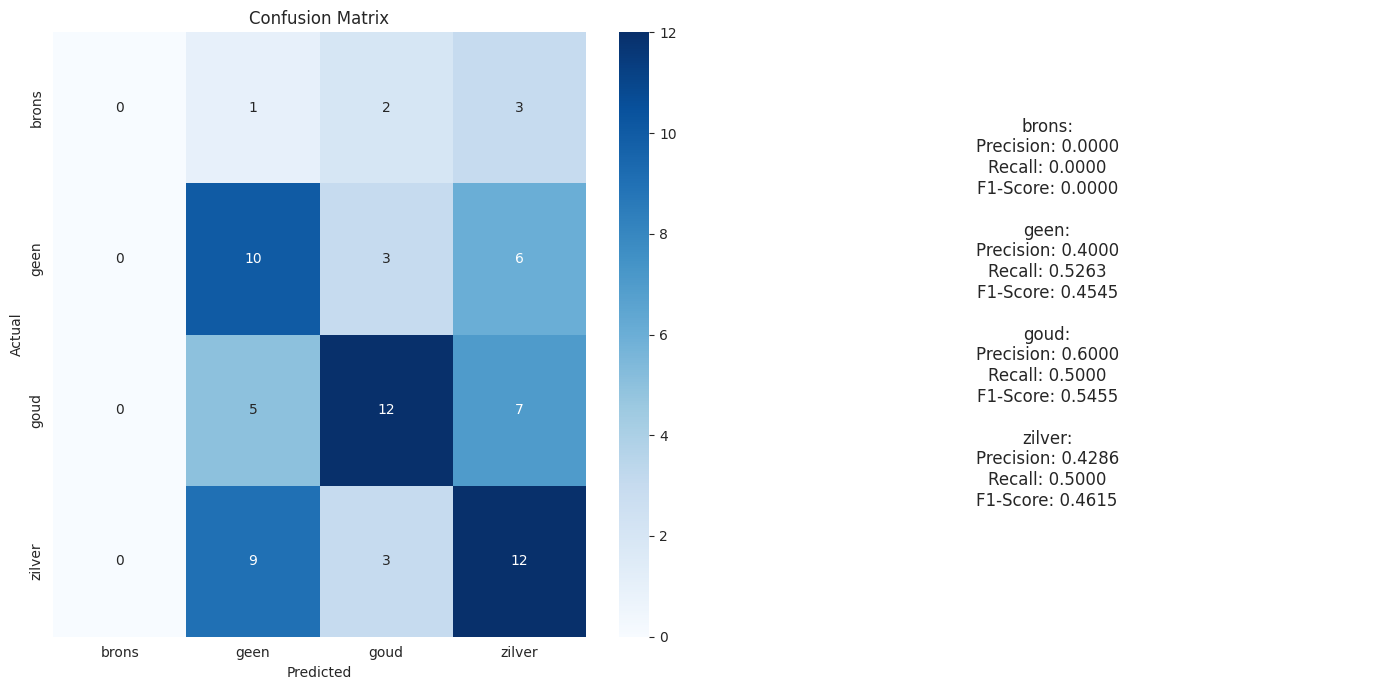

In [5]:
# Load the dataset and replace "ONBEKEND" with NaN
file_path = './data/examen2.csv'
ex_dataset2 = pd.read_csv(file_path, delimiter=';', na_values='ONBEKEND', decimal=',')

# Select the columns 'prijs' and 'LDA.prijs'
ex_eval = ex_dataset2[['prijs', 'LDA.prijs']]

# Remove rows with NaN values in 'prijs' or 'LDA.prijs'
ex_eval = ex_eval.dropna(subset=['prijs', 'LDA.prijs'])

# Create the confusion matrix
conf_matrix = confusion_matrix(ex_eval['prijs'], ex_eval['LDA.prijs'])

# Generate a classification report to get recall for each class
class_report = classification_report(ex_eval['prijs'], ex_eval['LDA.prijs'], output_dict=True, zero_division=0)

# Extract the recall for the class 'geen'
recall_geen = class_report.get('geen', {}).get('recall', 0.0)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nRecall voor de klasse 'geen':", recall_geen)

# Create a DataFrame from the classification report
class_report_df = pd.DataFrame(class_report).transpose()

# Plot the confusion matrix using matplotlib and seaborn
plt.figure(figsize=(14, 7))

# Heatmap for the confusion matrix
ax = plt.subplot(1, 2, 1)
class_labels = ['brons', 'geen', 'goud', 'zilver']  # These are the actual class labels
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Text box for additional metrics
ax2 = plt.subplot(1, 2, 2)
ax2.axis('off')

metrics_text = ''
for label in class_labels:
    precision = class_report_df.loc[label, 'precision']
    recall = class_report_df.loc[label, 'recall']
    f1_score = class_report_df.loc[label, 'f1-score']
    metrics_text += f'{label}:\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1_score:.4f}\n\n'

ax2.text(0.5, 0.5, metrics_text, fontsize=12, va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

![Matrix](./media/4.png)*

Optimal Cutoff: 1.0
Specificity: 0.5263157894736843


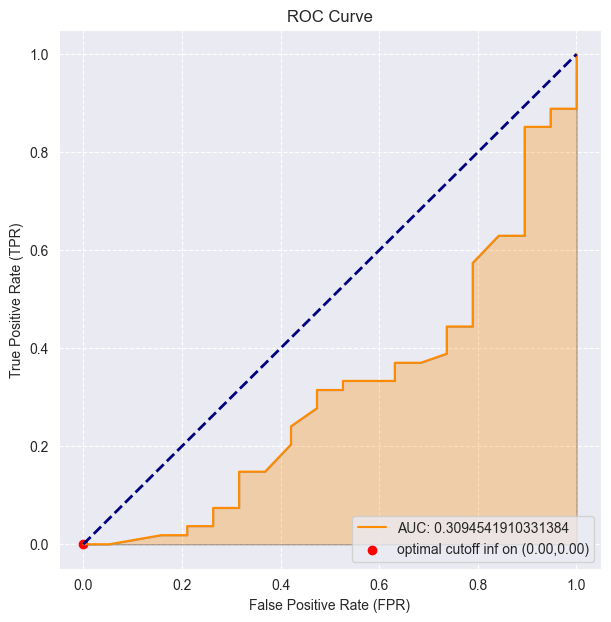

In [6]:
from res.Functions import plot_rocf

# Load the dataset and replace "ONBEKEND" with NaN
file_path = './data/examen2.csv'
ex_dataset2 = pd.read_csv(file_path, delimiter=';', na_values='ONBEKEND', decimal=',')

# Step 2: Create a new dataframe with the necessary columns
df_eval = ex_dataset2[['prijs', 'LDA.prijs', 'LDA.score']]

# Remove rows with NA values in 'prijs' or 'LDA.prijs'
df_eval = df_eval.dropna(subset=['prijs', 'LDA.prijs'])

# Replace the values as instructed
df_eval['prijs'] = df_eval['prijs'].replace(['goud', 'zilver', 'brons'], 'medaille')
df_eval['LDA.prijs'] = df_eval['LDA.prijs'].replace(['goud', 'zilver', 'brons'], 'medaille')

# Step 3: Calculate specificity for the optimal cutoff in ROC curve
# Convert 'prijs' to a binary variable (1 for 'medaille', 0 otherwise)
df_eval['prijs'] = df_eval['prijs'].apply(lambda x: 1 if x == 'medaille' else 0)
df_eval['LDA.prijs'] = df_eval['LDA.prijs'].apply(lambda x: 1 if x == 'medaille' else 0)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(df_eval['prijs'], df_eval['LDA.prijs'])

# Find the optimal cutoff point (Youden's J statistic)
J = tpr - fpr
ix = J.argmax()
optimal_cutoff = thresholds[ix]

# Calculate specificity
specificity = 1 - fpr[ix]

# Display the optimal cutoff and specificity
print("Optimal Cutoff:", optimal_cutoff)
print("Specificity:", specificity)

plot_rocf(df_eval['prijs'], df_eval['LDA.score'])


F![Matrix](./media/5.png)*

De kleinste absolute waarde is 0.80395 (J), dus het antwoord is ´J´

![Matrix](./media/6.png)*


1. **Beginstad identificeren:** We beginnen in stad D.
2. **Afstanden vanuit stad D bepalen:**
    * De afstanden van stad D naar andere steden zijn:
        * D naar A: 12
        * D naar B: 10
        * D naar C: 17
3. **Zoek de dichtbijtende stad:** De dichtstbijzijnde stad vanuit D is stad B met een afstand van 10.

**Conclusie:**
De reiziger gaat naar stad B wanneer hij uit stad D vertrekt, omdat stad B de dichtstbijzijnde stad is volgens de nearest neighbour heuristiek.

Als je meer steden wilt bezoeken, herhaal je dit proces door vanuit de nieuwe stad (in dit geval stad B) de dichtstbijzijnde nog niet bezochte stad te vinden, en zo verder te gaan tot alle steden bezocht zijn.

![Matrix](./media/7.png)*

In [7]:
import numpy as np

def objective_function(X):
    return np.sum([10 * (x_i - x_i**2) + (1 - x_i)**2 for x_i in X])

# Initial solution X
X = np.array([i + 3 for i in range(1, 26)])

# Calculate the objective function value
f_X = objective_function(X)
print(f_X)

-66075


![Matrix](./media/8.png)*

In [8]:
# Define the fitness function
def evaluate(x):
    return (0.2 + x[0]*x[0] + x[1]*x[1] - 0.1 * np.cos(6.0*math.pi*x[0]) - 0.1 * np.cos(6.0*math.pi*x[1]))

# Define the population
x1 = [1.0, 0.5]
x2 = [0.5, 0.0]
x3 = [0.5, 0.5]
x4 = [-0.75, -0.75]
x5 = [-0.5, -1.0]
x6 = [0.5, -0.5]
x7 = [1.0, 1.0]
x8 = [-0.5, -0.5]
x9 = [-1.0, -1.0]
x10 = [0.75, 0.75]

pop = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]

# Calculate fitness for each individual
fitness = [evaluate(individual) for individual in pop]

# Calculate the total fitness
total_fitness = sum(fitness)

# Calculate selection probabilities for each individual
selection_probabilities = [f / total_fitness for f in fitness]

# Perform roulette wheel selection to choose two individuals
selected_indices = np.random.choice(range(len(pop)), size=2, p=selection_probabilities)

# Print the fitness values
print("Fitness values:")
for i, f in enumerate(fitness, start=1):
    print(f"x{i}: {f}")

# Print the selection probabilities
print("\nSelection probabilities:")
for i, p in enumerate(selection_probabilities, start=1):
    print(f"x{i}: {p}")

# Print the selected individuals
print("\nSelected individuals:")
for i in selected_indices:
    print(f"x{i+1}: {pop[i]}")

Fitness values:
x1: 1.45
x2: 0.45000000000000007
x3: 0.8999999999999999
x4: 1.325
x5: 1.45
x6: 0.8999999999999999
x7: 2.0
x8: 0.8999999999999999
x9: 2.0
x10: 1.325

Selection probabilities:
x1: 0.1141732283464567
x2: 0.03543307086614174
x3: 0.07086614173228346
x4: 0.10433070866141733
x5: 0.1141732283464567
x6: 0.07086614173228346
x7: 0.15748031496062992
x8: 0.07086614173228346
x9: 0.15748031496062992
x10: 0.10433070866141733

Selected individuals:
x10: [0.75, 0.75]
x10: [0.75, 0.75]


![Matrix](./media/9.png)*


![Matrix](./media/10.png)*


In [9]:
# Load the dataset and replace "ONBEKEND" with NaN
file_path = './data/examen2.csv'
ex_dataset2 = pd.read_csv(file_path, delimiter=';', na_values='ONBEKEND', decimal=',')

# Scale the 'bedrag' column using the tanh function
ex_dataset2['bedrag_scaled'] = np.tanh(ex_dataset2['bedrag'])

# Calculate the standard deviation of the scaled 'bedrag' variable
std_dev_scaled_bedrag = ex_dataset2['bedrag_scaled'].std()

std_dev_scaled_bedrag

0.0

The standard deviation of the scaled variable `bedrag` is `0.0`. This result indicates that after applying the tanh function, all the scaled values are identical.

This might happen if all the values in the bedrag column were either very large or very small, leading the tanh function to push all values to the limits of `−1` or `1`
To verify this, let's inspect the scaled values.

In [10]:
# Summary statistics of the 'bedrag' column
bedrag_summary = ex_dataset2['bedrag'].describe()
bedrag_summary

count      95.000000
mean     1529.362842
std       186.253460
min      1128.200000
25%      1396.745000
50%      1506.190000
75%      1648.545000
max      2035.000000
Name: bedrag, dtype: float64